# Chapter 3: Least Mean Square

## Imports 

In [1]:
import os, sys
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
sources_path = './../Sources'
if sources_path not in sys.path:
    sys.path.append(sources_path)
from adaptive_filtering.lms import SignError
from adaptive_filtering.utils import rolling_window, generate_learning_plots

j = complex(0,1)

## Problem 8


In [11]:
output_filepath = './Outputs/Chap_4/Exercise_9/'
N = 11+1 # Number of coefficients
sigma_x2 = .5
sigma_n2 = 1e-3
R = sigma_x2*np.eye(N)
mse_estimate = sigma_x2
mse_min_estimate = sigma_x2
mu_max = (np.sqrt(np.pi*mse_estimate/2)/np.trace(R))
print ('mu_max: ', mu_max)

mu_max:  0.14770448757545965


In [8]:
K = 100             # number of iterations (signal length)
mu = .01*mu_max
def run_problem_8(K, mu):
    d = np.zeros([K]) # Desired signal        
    x = np.random.uniform(-1, 1, K)
    x = (x-x.mean())/np.sqrt(x.var()/sigma_x2) # Input signal
    n = np.sqrt(sigma_n2/2)*(np.random.normal(size=K)) # Noise signal

    for k in np.arange(K):
        d[k] = .9*d[k-1]+x[k]+n[k] if k != 0 else x[k]+n[k]

    # Fitting algorithm
    model = SignError(step=mu, filter_order=N-1, init_coef=np.ones([N]))
    model.fit(d, x)  
    
    return model, n

model, n = run_problem_8(K, mu)
print (model)

SignError(step=0.0014770448757545965, filter_order=11)


### (b)

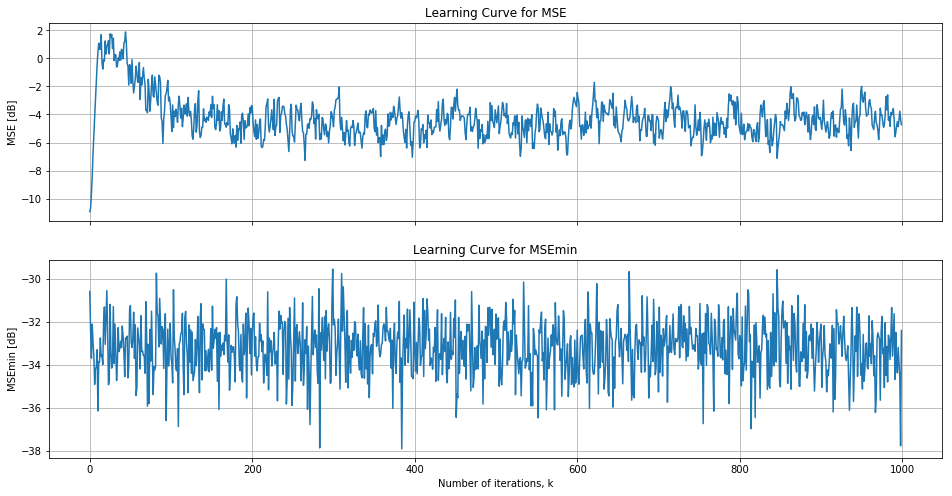

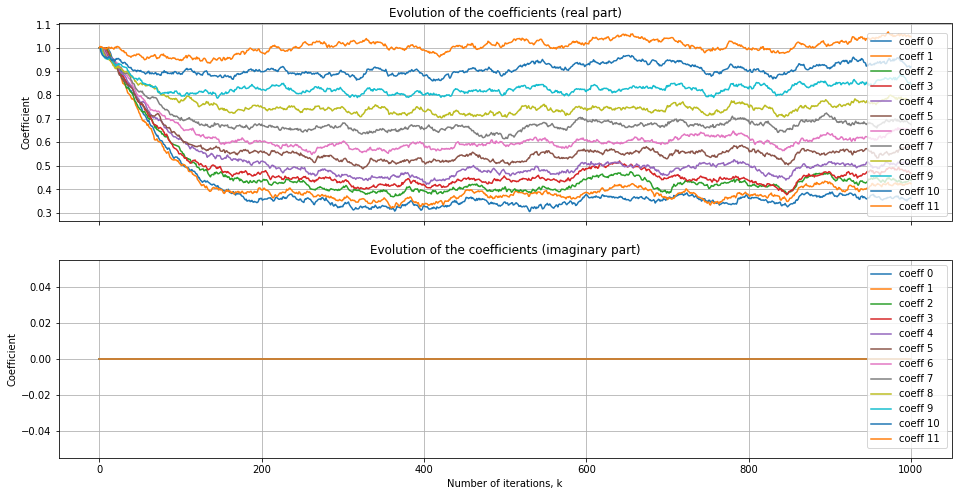

In [18]:
n_ensembles = 25   # number of realizations within the ensemble
K = 1000
W = np.ones([n_ensembles, K+1, N]) 
MSE = np.zeros([n_ensembles, K]) # MSE vector for each realization
MSE_min = np.zeros([n_ensembles, K]) # Minimum MSE for each realization 
frac = 10
mu = mu_max/frac

for ensemble in np.arange(n_ensembles):    
    model, n = run_problem_8(K, mu)         

    W[ensemble] = np.real(model.coef_vector)
    MSE[ensemble] = MSE[ensemble] + np.real(np.absolute(model.error_vector)**2)
    MSE_min[ensemble] = MSE_min[ensemble] + np.real(np.absolute(n**2))
    
W_av = np.sum(W, axis=0)/n_ensembles
MSE_av = sum(MSE, 2)/n_ensembles
MSEmin_av = np.sum(MSE_min, axis=0)/n_ensembles

# Generating plots    
generate_learning_plots(K, N, MSE_av, MSEmin_av, W_av, None, output_filepath=None, algorithm='LMS_run'+str(n_ensembles) )

### (c)

mu_max/10: M_theoretical = 0.15707963267948963


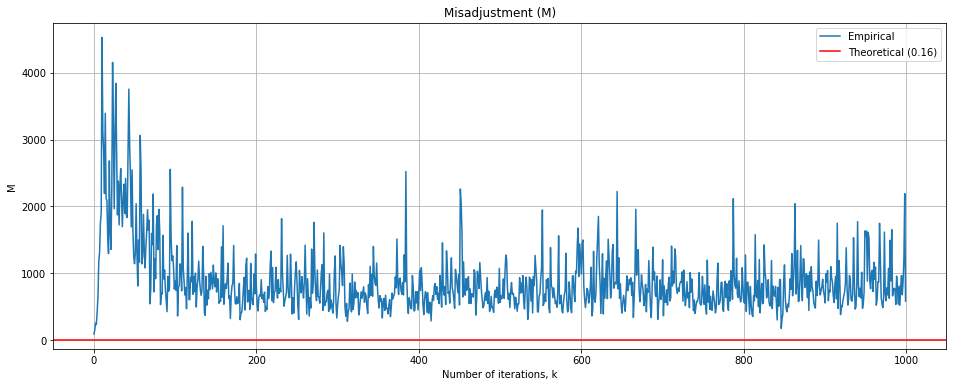

In [20]:
M = lambda mu: mu*np.sqrt(np.pi/(2*mse_min_estimate))*np.trace(R)
m_theoretical = M(mu)
print ('mu_max/{}: M_theoretical = {}'.format(frac, M(mu)))

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(16,6))
ax.plot((MSE_av-MSEmin_av)/MSEmin_av, label='Empirical')
ax.axhline(m_theoretical, color='r', label='Theoretical ({:.02f})'.format(m_theoretical))
ax.grid(True)
ax.set_title('Misadjustment (M)'), ax.set_xlabel('Number of iterations, k'), ax.set_ylabel('M')
ax.legend()

# if output_filepath is not None:        
#     fig.savefig(output_filepath + 'c_misadjustment_mu'+str(div)+'.jpg', bbox_inches = 'tight')